In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from pathlib import Path

In [5]:
df = pd.read_excel('main/data/train.xlsx')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'main/data/train.xlsx'

In [ ]:
df.shape

(400, 2)

In [ ]:
print("\nПропущенные значения:")
print(df.isnull().sum())
print("\nКоличество дубликатов:")
print(df.duplicated().sum())
print("\nОписательная статистика:")
df.describe()
#df['Цена на арматуру'].describe()


Пропущенные значения:
dt                  0
Цена на арматуру    0
dtype: int64

Количество дубликатов:
0

Описательная статистика:


,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


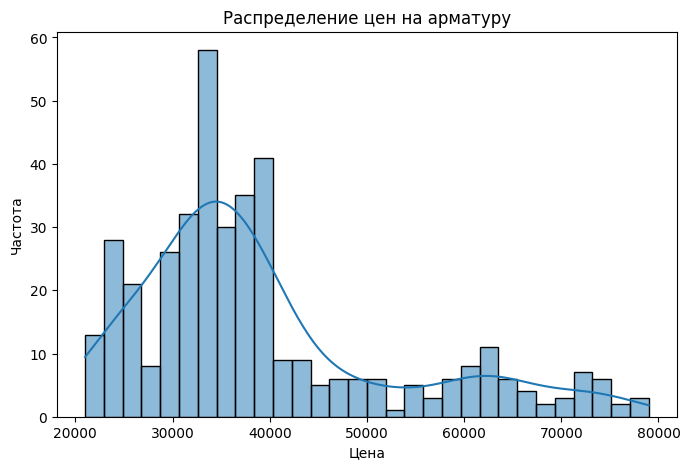

In [ ]:
column = 'Цена на арматуру'
plt.figure(figsize=(8, 5))
sns.histplot(df[column], bins=30, kde=True)
plt.title("Распределение цен на арматуру")
plt.xlabel("Цена")
plt.ylabel("Частота")
plt.show()

In [ ]:
print(df.columns)  # Выведет все столбцы DataFrame

Index(['dt', 'Цена на арматуру'], dtype='object')


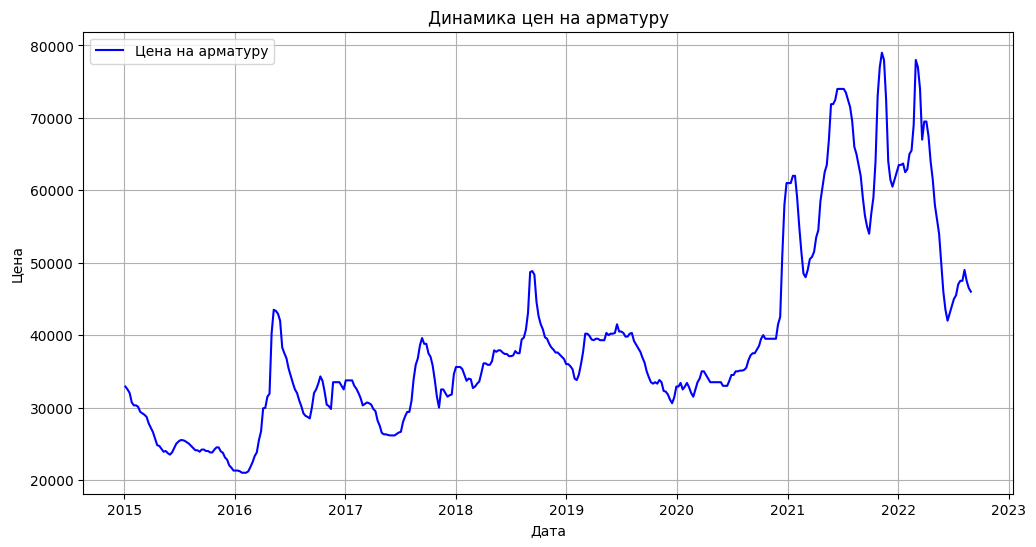

In [ ]:
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Цена на арматуру'], label='Цена на арматуру', color='b')
plt.title('Динамика цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()

NameError: name 'df' is not defined

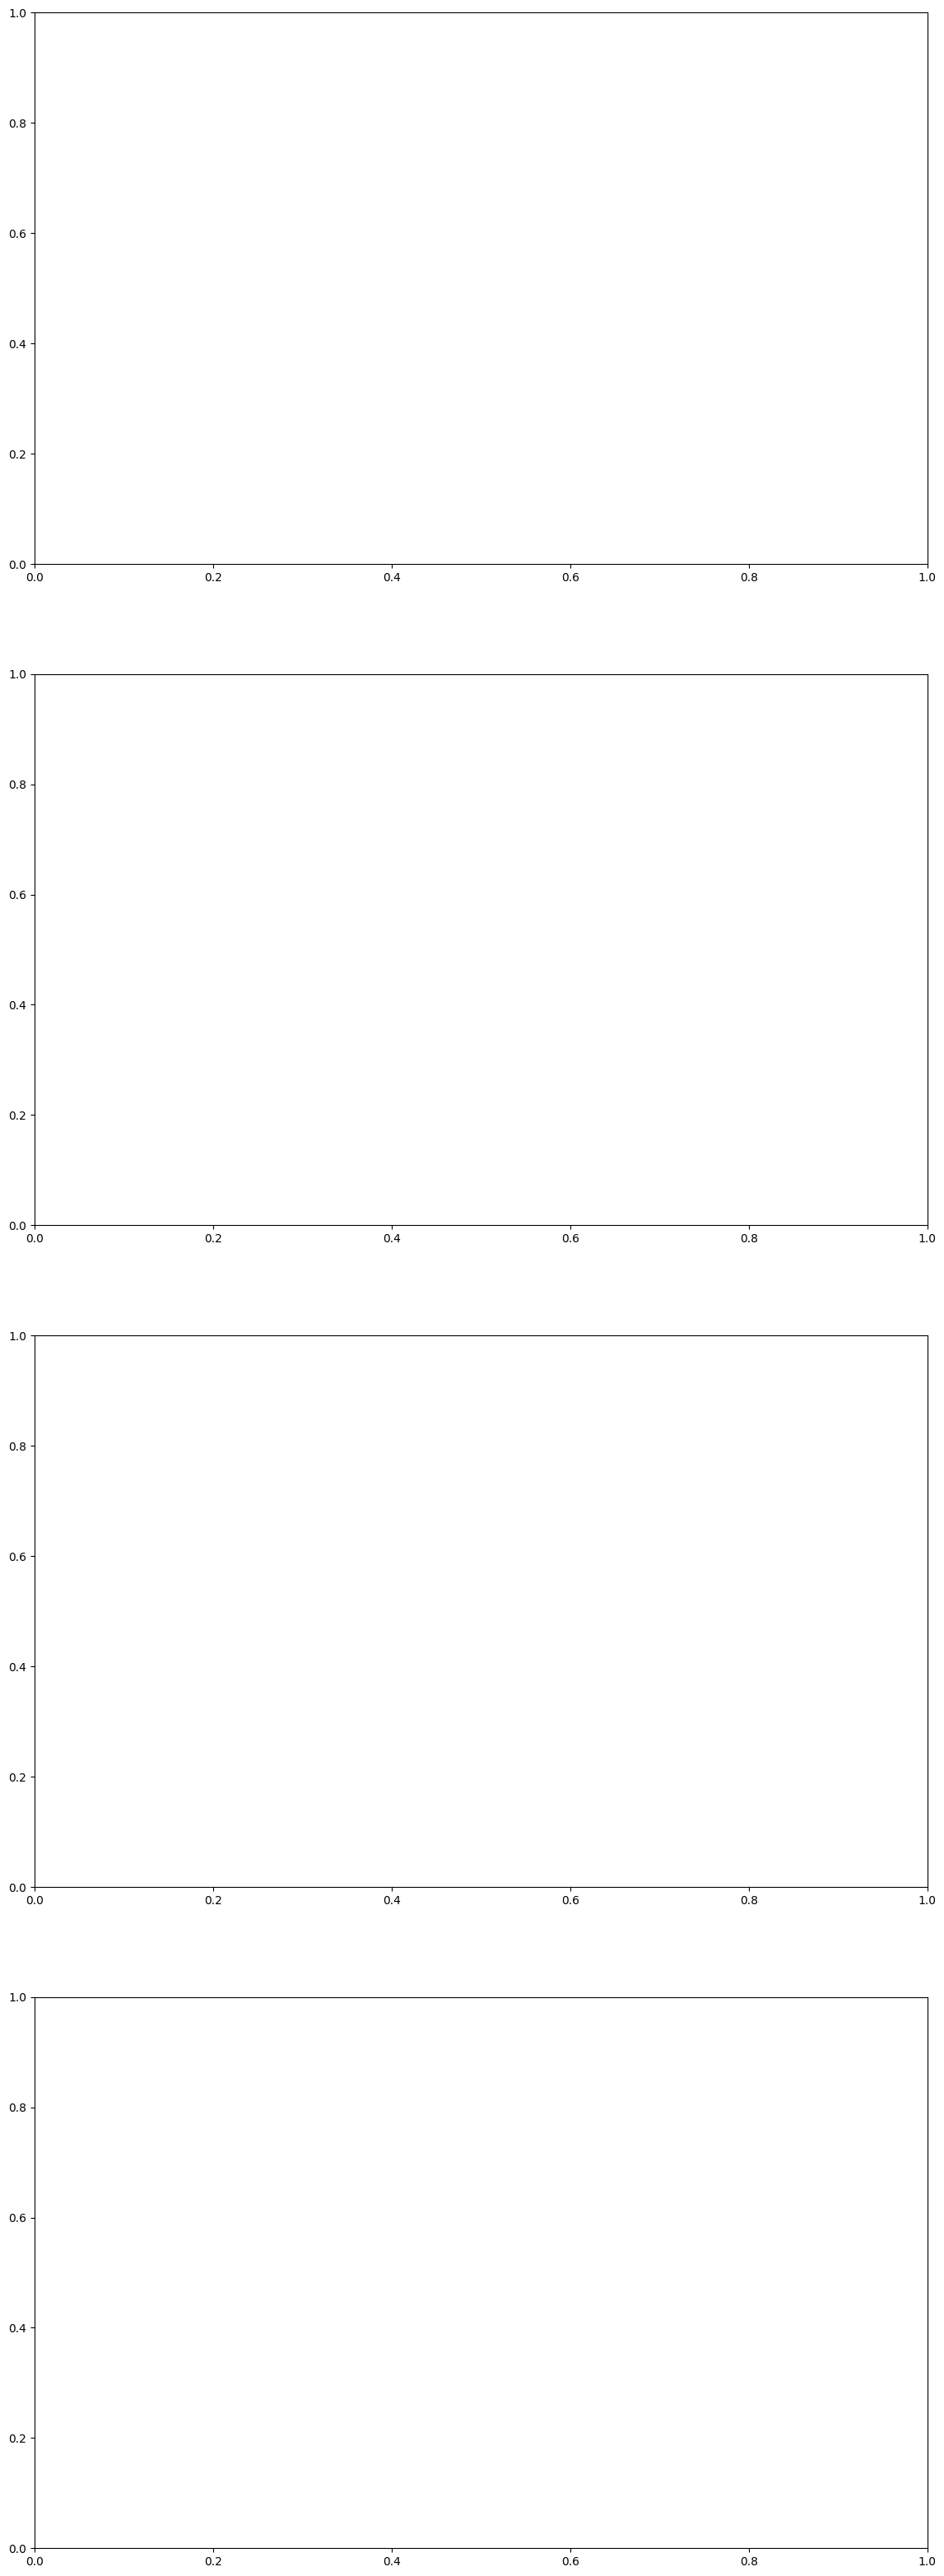

In [4]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
#decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [ ]:
print(df.columns)

Index(['Цена на арматуру'], dtype='object')


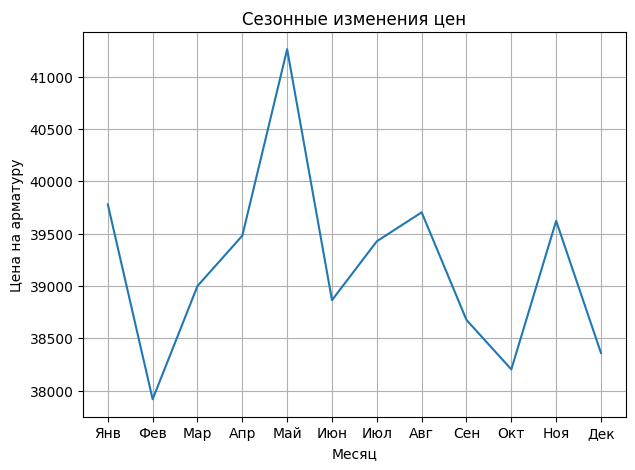

In [ ]:
df['month'] = df.index.month
plt.figure(figsize=(7, 5))
sns.lineplot(x=df['month'], y=df['Цена на арматуру'], errorbar=None)
plt.xlabel('Месяц')  # Подпись оси X
plt.ylabel('Цена на арматуру')  # Подпись оси Y (возможно, здесь ошибка, так как строится цена на арматуру)
plt.title('Сезонные изменения цен')  # Заголовок графика
plt.xticks(range(1, 13), labels=[
    'Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
    'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(True)
plt.show()

переименовать файл в анализ данных чтобы без вопросов